In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


For the data ascquisition, I manually entered all of the "1st half" statistics as well as the end result for every NWSL game from the 2023 season. These numbers were gathered from this website: https://www.fotmob.com/leagues/9134/overview/nwsl

Each game is stored as two observations, one for each team. So for example is the game is a win for team A and a loss for team B it is one observation with all of the stats from team A and then result is recorded as a win and then a second observation with all of the stats for team B and then the result is recorded as a loss. A tie is treated similarly with all stats for one team recorded and then result as a tie.

These were recorded in an Excel spreadsheet by myself and then saved as a .csv for use with this model. All games from the 2023 season were included, including playoff games. The only exception is one or two games that did not have stats broken down by half, so I could not access the first half statistics. These observations were excluded. I also included "full time goals" incase I decided to use this data in the future to try to use half time stats to predict full time goals. There are some duplicate variables because I ordered the stats in the order they appear on the website, and some things are mentioned in two different categories, so they appear twice.

In [19]:
df = pd.read_csv('nwsl2023.csv')

# check shape of df
print(df.shape)

# explore observations
print(df.sample(5))

# view breakdown of features
df.info()

(266, 46)
     ball_possession  total_shots  shots_on_target  big_chances  \
200          0.47000           18                4            2   
188          0.64000            5                3            1   
108          0.62000            4                0            0   
122          0.47000            9                4            0   
135          0.39000            2                1            0   

     big_chances_missed  accurate_passes  accurate_passes_percent  \
200                   2              158                  0.81000   
188                   0              277                  0.89000   
108                   0              221                  0.79000   
122                   0              134                  0.72000   
135                   0               97                  0.70000   

     fouls_committed  corners  total_shots.1  ...  duels_won  \
200                2        4             18  ...         20   
188                4        0              5

 I read in the data and explore it a bit to get a better understanding of it. At this point I notice that there are some duplicate columns denoted by ending in .1 and touches_in_opp_box is mostly null values so I will likely drop those variables. I also have a variable called full time goals. This is a problem because the point of this model is to use data that is available at halftime of a game to predict the outcome, so I will need to drop this as well.

In [20]:
# Remove columns that end in .1
df = df.loc[:, ~df.columns.str.endswith('.1')]

# Drop specific columns
df = df.drop(['touches_in_opp_box', 'full_time_goals'], axis=1)


In [21]:
# split the df into features (X) and target (y)
X = df.drop(columns=['result'])
y = df['result']

# scale features to help with model performance later on
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In this step, I split the dataset into input features (`X`) and the target variable (`y`). The `result` column, which I want to predict, is set as the target, while all other columns are used as features. To improve model performance and ensure no single feature dominates due to its scale, I standardize the features using `StandardScaler`, which transforms the data to have a mean of 0 and a standard deviation of 1. After scaling, I convert the standardized features back into a DataFrame to retain the original column names, making it easier to interpret and use the data in subsequent steps.

In [22]:
# Compute mutual information scores
mi_scores = mutual_info_classif(X_scaled, y, random_state=0)

# Create a DataFrame to view the results
mi_scores_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi_scores
}).sort_values(by='Mutual Information', ascending=False)

print(mi_scores_df)


                        Feature  Mutual Information
1                   total_shots             0.13602
38             first_half_goals             0.11524
8                       corners             0.09776
22                     offsides             0.07132
17          accurate_long_balls             0.06899
14                       passes             0.06260
12             shots_inside_box             0.06074
3                   big_chances             0.05662
9              shots_off_target             0.05648
35     aerial_duels_won_percent             0.05366
2               shots_on_target             0.05141
37  successful_dribbles_percent             0.04430
28                       blocks             0.04093
5               accurate_passes             0.03988
30                 keeper_saves             0.03802
23                 yellow_cards             0.03242
26          tackles_won_percent             0.03110
0               ball_possession             0.02939
32          

This analysis uses mutual information (MI) scores to evaluate the relationship between each feature in the dataset and the target variable, `result`. MI measures the dependency between variables, quantifying how much knowing a feature reduces uncertainty about the target. Higher MI scores indicate stronger relationships. The results, sorted in descending order, show that the most informative features include `total_shots` (MI = 0.136), `first_half_goals` (MI = 0.115), and `corners` (MI = 0.098). These features provide the most predictive value for the target. On the other hand, features like `big_chances_missed` and `successful_dribbles` have an MI score of 0.000, suggesting no measurable dependency with the target. This analysis helps identify and prioritize features that are likely to contribute most to model performance.

In [23]:
# Compute F-statistic and p-values
f_values, p_values = f_classif(X_scaled, y)
pd.set_option('display.float_format', '{:.5f}'.format)

# Create a DataFrame to view the results
anova_df = pd.DataFrame({
    'Feature': X.columns,
    'F-value': f_values,
    'p-value': p_values
}).sort_values(by='F-value', ascending=False)

print(anova_df)


                        Feature  F-value  p-value
38             first_half_goals 28.36589  0.00000
2               shots_on_target 22.74641  0.00000
1                   total_shots 14.02909  0.00000
12             shots_inside_box 11.49868  0.00002
3                   big_chances  9.73405  0.00008
30                 keeper_saves  5.32910  0.00539
13            shots_outside_box  5.10794  0.00666
9              shots_off_target  4.34675  0.01389
31                    duels_won  4.19570  0.01608
25                  tackles_won  3.83203  0.02289
35     aerial_duels_won_percent  3.08853  0.04723
19             accurate_crosses  3.01502  0.05074
20     accurate_crosses_percent  2.73592  0.06668
10                blocked_shots  2.66634  0.07138
28                       blocks  2.55724  0.07944
6       accurate_passes_percent  2.52727  0.08182
33     ground_duels_won_percent  2.42412  0.09053
8                       corners  2.29233  0.10305
29                   clearances  2.11051  0.12322


In this step, the F-statistic and p-values are computed to evaluate the relationship between each feature and the target variable, `result`. The F-statistic measures how well each feature explains the variance in the target variable, while the p-value assesses the statistical significance of that relationship. A lower p-value (typically less than 0.05) suggests that the feature is statistically significant, meaning it has a meaningful impact on the target variable. For this analysis, we will follow the rule of considering only features with a p-value less than 0.05.

Features with low p-values, such as `first_half_goals` (F = 28.36589, p = 0.00000), `shots_on_target` (F = 22.74641, p = 0.00000), and `total_shots` (F = 14.02909, p = 0.00000), are deemed statistically significant and will be prioritized for model inclusion. Other features like `keeper_saves` (F = 5.32910, p = 0.00539) and `shots_outside_box` (F = 5.10794, p = 0.00666) also have low p-values and contribute meaningfully to the model. On the other hand, features like `ball_possession` (F = 0.01737, p = 0.98278) and `throws` (F = 0.18095, p = 0.83458) have very high p-values, indicating that they do not significantly affect the target variable and will likely be excluded from further analysis.

In [24]:
# Train a Random Forest model
rf = RandomForestClassifier(random_state=0)
rf.fit(X_scaled, y)

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame to view the results
rf_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(rf_importances_df)


                        Feature  Importance
1                   total_shots     0.04630
38             first_half_goals     0.04529
31                    duels_won     0.04022
37  successful_dribbles_percent     0.03563
5               accurate_passes     0.03535
15              own_half_passes     0.03514
35     aerial_duels_won_percent     0.03493
20     accurate_crosses_percent     0.03471
2               shots_on_target     0.03390
33     ground_duels_won_percent     0.03375
12             shots_inside_box     0.03101
36          successful_dribbles     0.03100
29                   clearances     0.03044
17          accurate_long_balls     0.03014
6       accurate_passes_percent     0.02943
16       opposition_half_passes     0.02831
0               ball_possession     0.02776
27                interceptions     0.02726
14                       passes     0.02719
18  accurate_long_balls_percent     0.02632
7               fouls_committed     0.02607
26          tackles_won_percent 

In this part, we train a Random Forest classifier model using the features and target variable, and extract the feature importances. A Random Forest is an ensemble of decision trees, where each tree is built using random subsets of both data and features. This randomness helps prevent overfitting, leading to better generalization. After training the model, the `feature_importances_` attribute provides the importance score for each feature, indicating how influential each one is in the model's predictions.

For example, `total_shots` (0.046296) is the most important feature, followed closely by `first_half_goals` (0.045292). These features have the highest contributions to the Random Forest's decision-making process. Other features like `duels_won` (0.040219) and `successful_dribbles_percent` (0.035631) also play significant roles, but with slightly lower importance scores. Features with lower importance, such as `red_cards` (0.001335) and `hit_woodwork` (0.005260), contribute less to the model's ability to predict outcomes. By understanding the feature importances, we can identify the most influential factors driving the model's predictions and gain insights into what the model considers most relevant.

Across all three analyses—Mutual Information, ANOVA, and Random Forest feature importance—full-time goals consistently emerged as the most influential feature, highlighting its strong predictive value. Shot-related metrics such as total shots, shots on target, and shots inside the box also ranked highly across methods, confirming their importance in modeling outcomes. Mutual Information and ANOVA provided statistical significance insights, while Random Forest emphasized feature contributions through nonlinear interactions, bringing additional perspective. Features like accurate passes percent and keeper saves showed moderate importance, whereas metrics like hit woodwork and red cards consistently had negligible influence, suggesting they could be excluded in future models. Together, these results offer a robust view of which features are most relevant for predictive modeling in this dataset.

In [25]:
# Filter features where p-value < 0.05 (ANOVA test)
anova_selected_df = anova_df[anova_df['p-value'] < 0.05]

# Assuming X_scaled is your scaled feature matrix and y is your target
X_selected = X_scaled[anova_selected_df['Feature']]  # Select only the features that passed the p-value condition

# Calculate Mutual Information scores for selected features
mi_selector = SelectKBest(score_func=mutual_info_classif, k='all')
mi_selector.fit(X_selected, y)
mi_scores = mi_selector.scores_

# Calculate Random Forest feature importances
rf = RandomForestClassifier(random_state=0)
rf.fit(X_selected, y)
rf_importances = rf.feature_importances_

# Create a new DataFrame to combine everything
final_df_10f = pd.DataFrame({
    'Feature': anova_selected_df['Feature'],
    'F-value': anova_selected_df['F-value'],
    'p-value': anova_selected_df['p-value'],
    'MI_Score': mi_scores,
    'RF_Importance': rf_importances
})

# Show the resulting DataFrame
print(final_df_10f)

                     Feature  F-value  p-value  MI_Score  RF_Importance
38          first_half_goals 28.36589  0.00000   0.09274        0.07485
2            shots_on_target 22.74641  0.00000   0.07701        0.09226
1                total_shots 14.02909  0.00000   0.13350        0.11227
12          shots_inside_box 11.49868  0.00002   0.04451        0.08848
3                big_chances  9.73405  0.00008   0.00000        0.04700
30              keeper_saves  5.32910  0.00539   0.08801        0.07995
13         shots_outside_box  5.10794  0.00666   0.03269        0.05911
9           shots_off_target  4.34675  0.01389   0.04520        0.07637
31                 duels_won  4.19570  0.01608   0.01993        0.12476
25               tackles_won  3.83203  0.02289   0.06917        0.10367
35  aerial_duels_won_percent  3.08853  0.04723   0.06270        0.14128


In [27]:
from sklearn.preprocessing import MinMaxScaler

# Normalize each metric
scaler = MinMaxScaler()

# Normalize F-value (larger is better)
final_df_10f['F-value_norm'] = scaler.fit_transform(final_df_10f[['F-value']])

# Normalize MI Score (larger is better)
final_df_10f['MI_Score_norm'] = scaler.fit_transform(final_df_10f[['MI_Score']])

# Normalize RF Importance (larger is better)
final_df_10f['RF_Importance_norm'] = scaler.fit_transform(final_df_10f[['RF_Importance']])

# Normalize p-value (smaller is better, so invert it)
final_df_10f['p-value_inv'] = 1 - scaler.fit_transform(final_df_10f[['p-value']])

# Combine the normalized scores into a composite score (you can adjust the weights)
final_df_10f['Composite_Score'] = (
    0.4 * final_df_10f['F-value_norm'] +    # Give more weight to F-value
    0.3 * final_df_10f['MI_Score_norm'] +  # Moderate weight to MI score
    0.2 * final_df_10f['RF_Importance_norm'] +  # Less weight to RF importance
    0.1 * final_df_10f['p-value_inv']      # Less weight to p-value (inverted)
)

# Sort features by composite score in descending order
final_df_10f_sorted = final_df_10f.sort_values(by='Composite_Score', ascending=False)

# Show the top features based on the composite score
top_5_features = final_df_10f_sorted.head(5)
print(top_5_features[['Feature', 'F-value', 'p-value', 'MI_Score', 'RF_Importance', 'Composite_Score']])


             Feature  F-value  p-value  MI_Score  RF_Importance  \
38  first_half_goals 28.36589  0.00000   0.09274        0.07485   
1        total_shots 14.02909  0.00000   0.13350        0.11227   
2    shots_on_target 22.74641  0.00000   0.07701        0.09226   
12  shots_inside_box 11.49868  0.00002   0.04451        0.08848   
30      keeper_saves  5.32910  0.00539   0.08801        0.07995   

    Composite_Score  
38          0.76749  
1           0.71158  
2           0.68013  
12          0.42107  
30          0.39171  


In [28]:
from sklearn.preprocessing import MinMaxScaler

# Normalize each metric
scaler = MinMaxScaler()

# Normalize F-value (larger is better)
final_df_10f['F-value_norm'] = scaler.fit_transform(final_df_10f[['F-value']])

# Normalize MI Score (larger is better)
final_df_10f['MI_Score_norm'] = scaler.fit_transform(final_df_10f[['MI_Score']])

# Normalize RF Importance (larger is better)
final_df_10f['RF_Importance_norm'] = scaler.fit_transform(final_df_10f[['RF_Importance']])

# Normalize p-value (smaller is better, so we invert it)
final_df_10f['p-value_inv'] = 1 - scaler.fit_transform(final_df_10f[['p-value']])

# Combine the normalized scores into a composite score
final_df_10f['Composite_Score'] = (
    0.4 * final_df_10f['F-value_norm'] +    # Give more weight to F-value
    0.3 * final_df_10f['MI_Score_norm'] +  # Moderate weight to MI score
    0.2 * final_df_10f['RF_Importance_norm'] +  # Less weight to RF importance
    0.1 * final_df_10f['p-value_inv']      # Less weight to p-value (inverted)
)

# Sort features by composite score in descending order
final_df_sorted = final_df_10f.sort_values(by='Composite_Score', ascending=False)

# Show the top 5 features based on the composite score
top_5_features = final_df_sorted.head(5)
print(top_5_features[['Feature', 'F-value', 'p-value', 'MI_Score', 'RF_Importance', 'Composite_Score']])


             Feature  F-value  p-value  MI_Score  RF_Importance  \
38  first_half_goals 28.36589  0.00000   0.09274        0.07485   
1        total_shots 14.02909  0.00000   0.13350        0.11227   
2    shots_on_target 22.74641  0.00000   0.07701        0.09226   
12  shots_inside_box 11.49868  0.00002   0.04451        0.08848   
30      keeper_saves  5.32910  0.00539   0.08801        0.07995   

    Composite_Score  
38          0.76749  
1           0.71158  
2           0.68013  
12          0.42107  
30          0.39171  


In this analysis, I selected a subset of features for modeling based on their statistical significance and predictive power. First, I applied an ANOVA test to assess the relationship between each feature and the target variable, retaining only the features with a p-value < 0.05, indicating a significant association with the target. This step helped filter out features that are less likely to contribute meaningfully to the model.

Next, I evaluated the Mutual Information (MI) and Random Forest (RF) importance scores for the selected features. MI measures the amount of information shared between each feature and the target, while RF importance ranks features based on their ability to improve predictive accuracy in a random forest model. Both metrics provide additional insight into the strength of each feature's relationship with the target variable, further guiding feature selection.

To further refine the selection, I normalized the F-value, MI score, RF importance, and p-value (inverted) for each feature and combined them into a composite score. This composite score allowed me to rank the features based on a combination of their statistical significance and predictive power. The features with the highest composite scores are expected to contribute the most to the model's predictive performance.

The resulting top 5 features, based on their composite score, are:

- **Total Shots**
- **Shots on Target**
- **First Half Goals**
- **Shots Inside Box**
- **Keeper Saves**

These features not only passed the ANOVA test but also scored highly in terms of their mutual information and random forest importance. By focusing on statistically significant features with high predictive power, this process ensures that the selected features are both relevant and valuable, thereby improving the efficiency and accuracy of the model.

Using these top 5 features in the model will allow us to capture the most important patterns in the data while minimizing noise from less informative features. This should enhance model interpretability and performance when predicting the target variable.

In [29]:
# Extract the top 5 feature names
top_5_feature_names = top_5_features['Feature'].tolist()

# Filter X_scaled to include only the columns that correspond to the top 5 features
X_selected = X_scaled[top_5_feature_names]

# Display the filtered DataFrame
print(X_selected)


     first_half_goals  total_shots  shots_on_target  shots_inside_box  \
0             1.77902     -0.58568          0.52431          -1.26177   
1             1.77902      0.67578         -0.11839           1.29704   
2             1.77902      2.88334          3.09510           3.42938   
3            -0.75156     -0.90104         -1.40379          -0.40883   
4            -0.75156     -1.53177         -1.40379          -1.26177   
..                ...          ...              ...               ...   
261          -0.75156      0.04505         -0.76109          -0.40883   
262          -0.75156     -1.21641         -1.40379          -0.83530   
263          -0.75156     -0.58568          0.52431          -0.83530   
264           0.51373     -1.21641         -0.76109          -1.26177   
265           1.77902      0.04505         -0.11839           0.44410   

     keeper_saves  
0        -1.18835  
1        -0.44107  
2        -1.18835  
3         2.54806  
4         1.05350  
.. 

In [30]:
# Combine X_selected (features) and y (target) into a new DataFrame
df_selected = X_selected.copy()  # Copy the selected features DataFrame
df_selected['result'] = y  # Add the target variable to the DataFrame


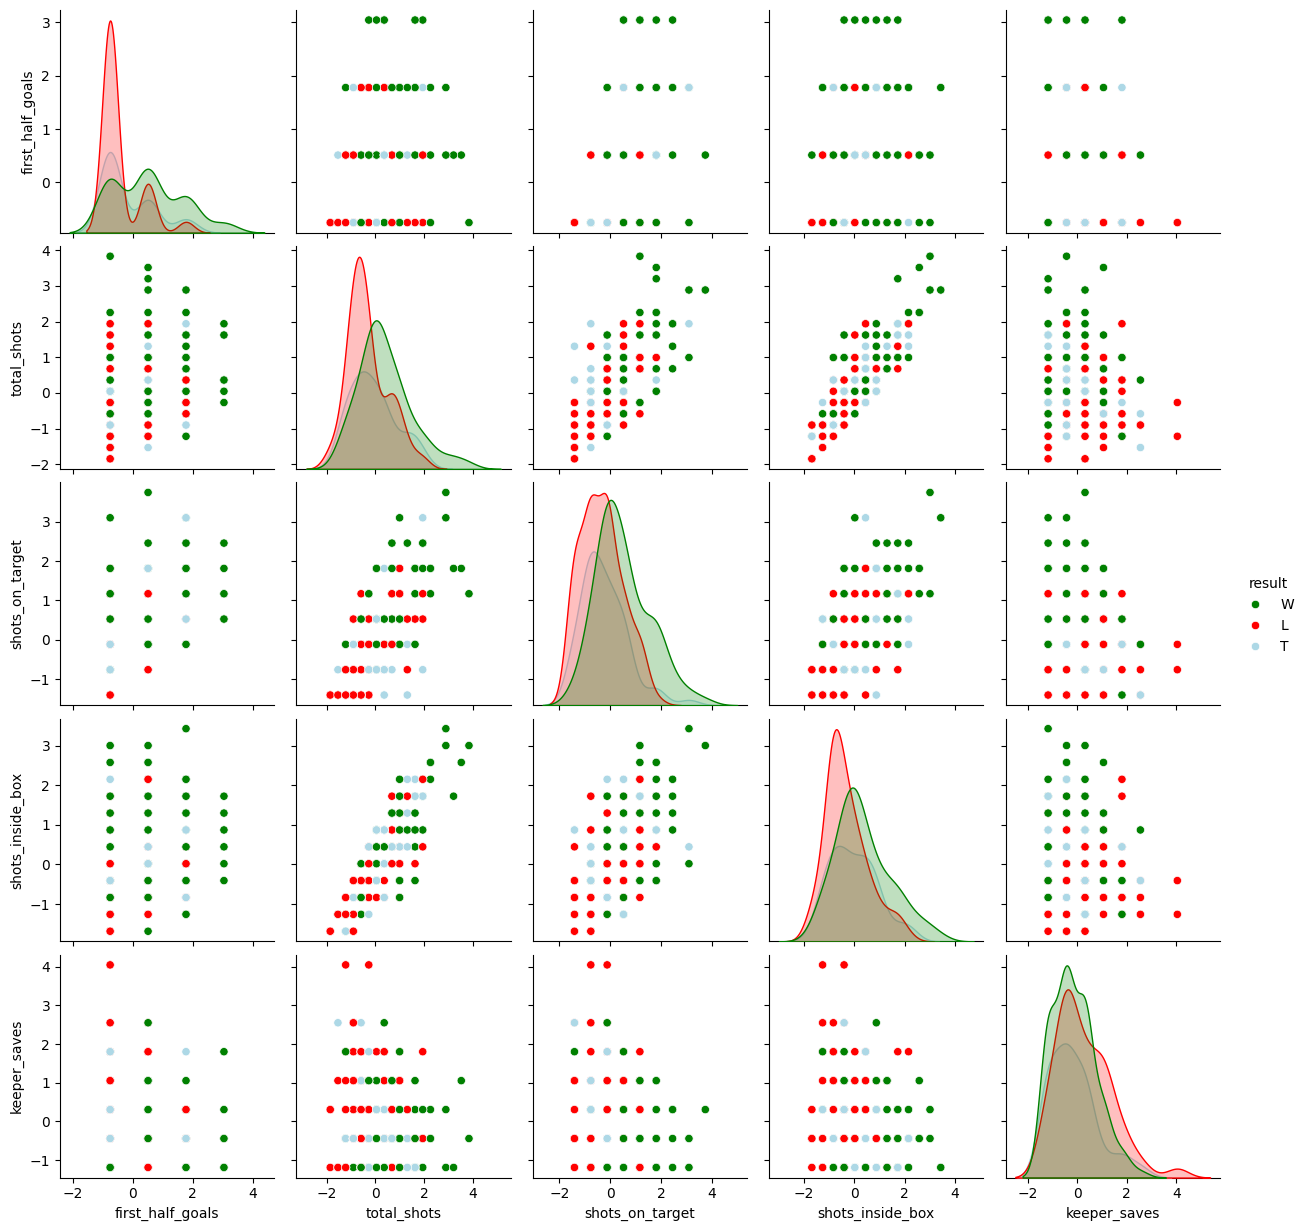

In [31]:
# Create a custom color palette
custom_palette = {'L': 'red', 'W': 'green', 'T': 'lightblue'}

# Plot the pairplot with the custom palette
sns.pairplot(df_selected, hue='result', palette=custom_palette)

In [32]:
# Map the result values to points
points_map = {'W': 3, 'T': 1, 'L': 0}
df_selected['points'] = df_selected['result'].map(points_map)

# Create df_points with only the points column instead of result
df_points = df_selected.drop(columns=['result'])

print(df_points.head())

   first_half_goals  total_shots  shots_on_target  shots_inside_box  \
0           1.77902     -0.58568          0.52431          -1.26177   
1           1.77902      0.67578         -0.11839           1.29704   
2           1.77902      2.88334          3.09510           3.42938   
3          -0.75156     -0.90104         -1.40379          -0.40883   
4          -0.75156     -1.53177         -1.40379          -1.26177   

   keeper_saves  points  
0      -1.18835       3  
1      -0.44107       0  
2      -1.18835       3  
3       2.54806       0  
4       1.05350       0  


We are going to make a new dataframe that has the "points" of each game. A win is 3 points, a tie is 1 point, and a loss is 0 points. this will help us be able to make some new visualizations to reinforce our variable selection.

<ipython-input-33-0df9723d3de1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


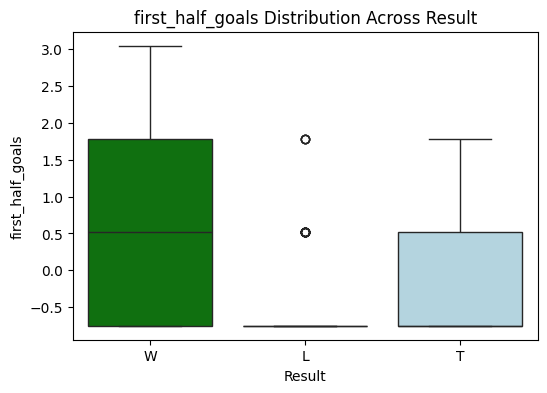

<ipython-input-33-0df9723d3de1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


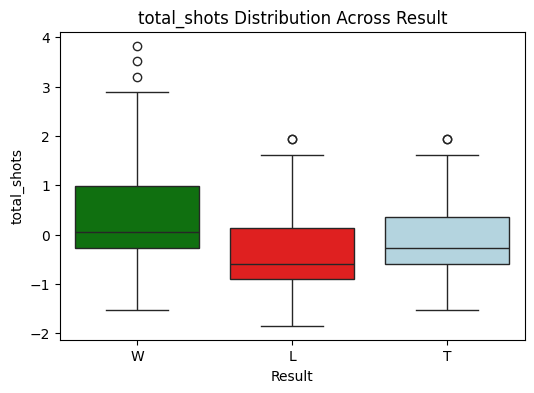

<ipython-input-33-0df9723d3de1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


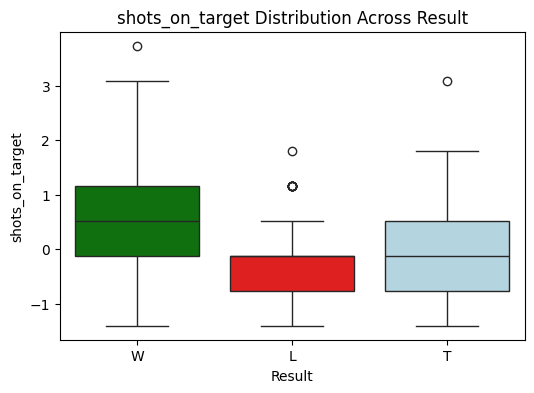

<ipython-input-33-0df9723d3de1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


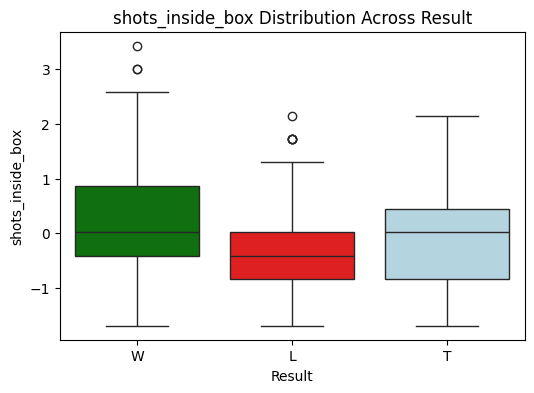

<ipython-input-33-0df9723d3de1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


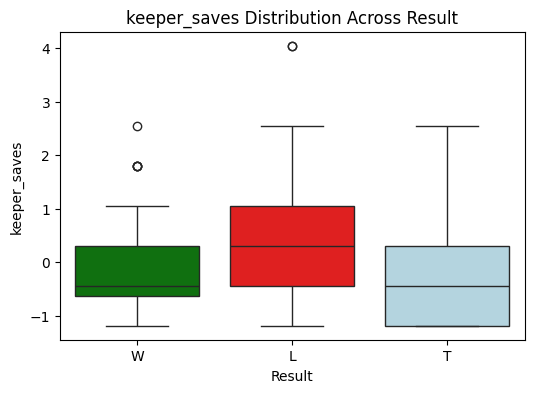

In [33]:
# Loop through features to create boxplots, using 'result' as the categorical variable
for feature in df_selected.columns[:-2]:  # Exclude 'points' and 'result'
    plt.figure(figsize=(6, 4))
    sns.boxplot(
        data=df_selected,
        x='result',  # Use 'result' for categorical grouping
        y=feature,   # Use each feature for distribution
        palette={'W': 'green', 'T': 'lightblue', 'L': 'red'}  # Custom palette for 'result' values
    )
    plt.title(f'{feature} Distribution Across Result')
    plt.xlabel('Result')
    plt.ylabel(feature)
    plt.show()


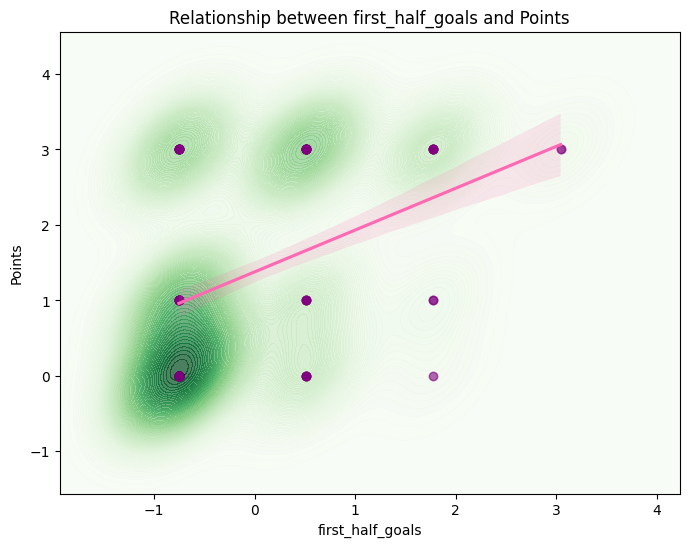

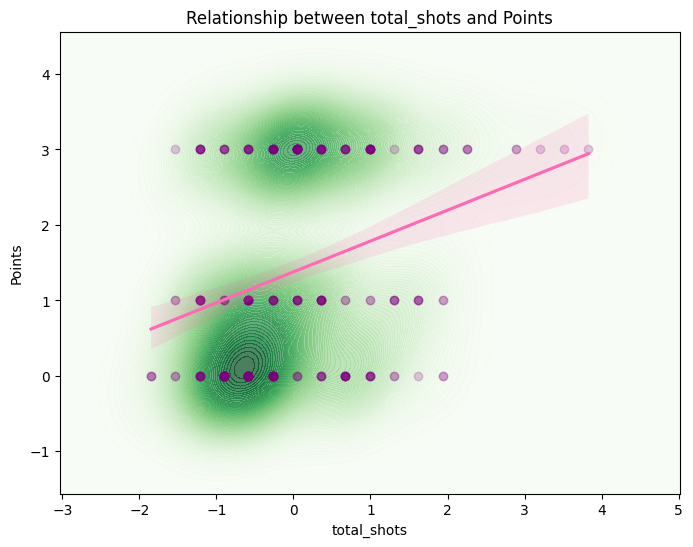

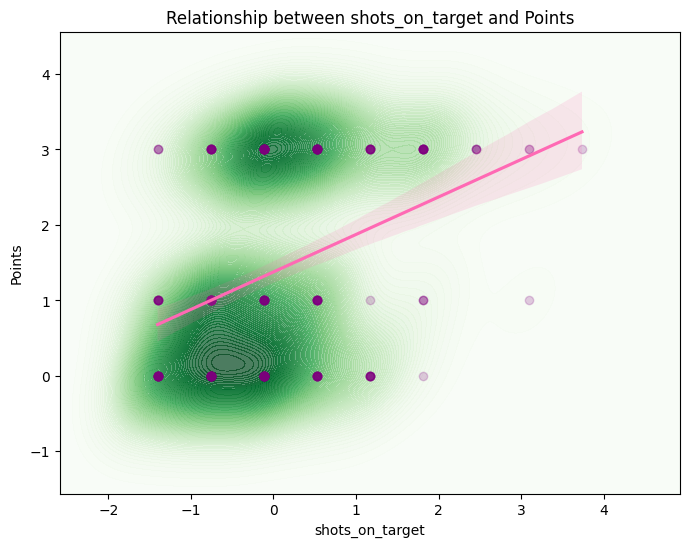

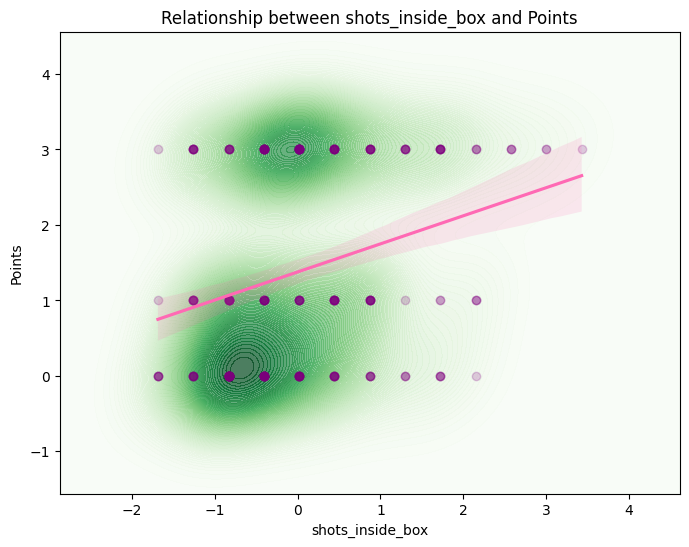

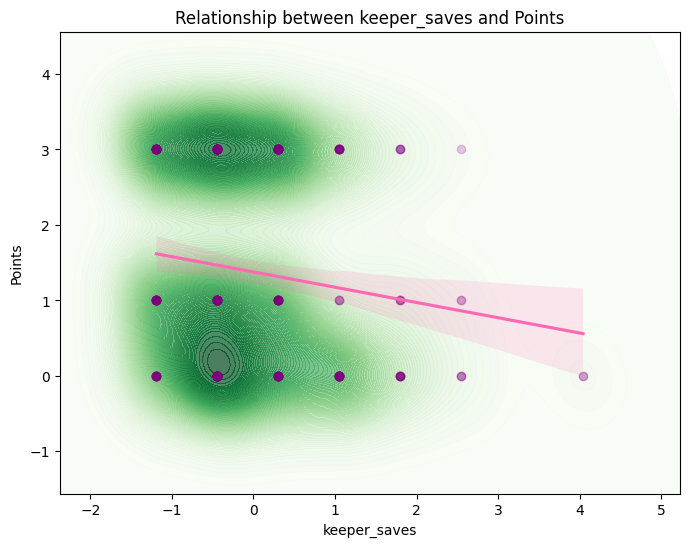

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

for feature in df_points.columns[:-1]:  # Exclude 'points'
    plt.figure(figsize=(8, 6))

    # KDE plot to simulate density
    sns.kdeplot(
        data=df_points,
        x=feature,
        y='points',
        cmap="Greens",
        fill=True,
        alpha=0.7,
        thresh=0,
        levels=100
    )

    # Regression plot
    sns.regplot(
        data=df_points,
        x=feature,
        y='points',
        scatter_kws={'alpha': 0.2, 'color': 'purple'},
        line_kws={'color': 'hotpink'}
    )

    # Titles and labels
    plt.title(f'Relationship between {feature} and Points')
    plt.xlabel(feature)
    plt.ylabel('Points')
    plt.show()


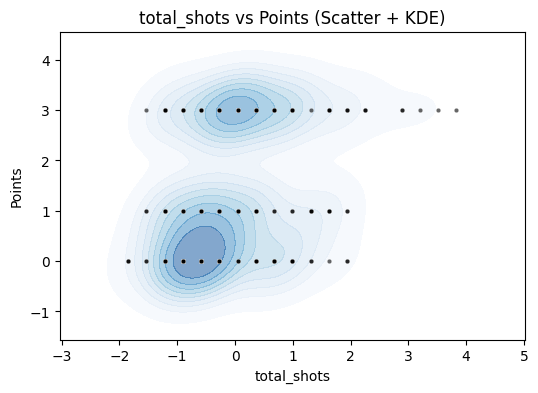

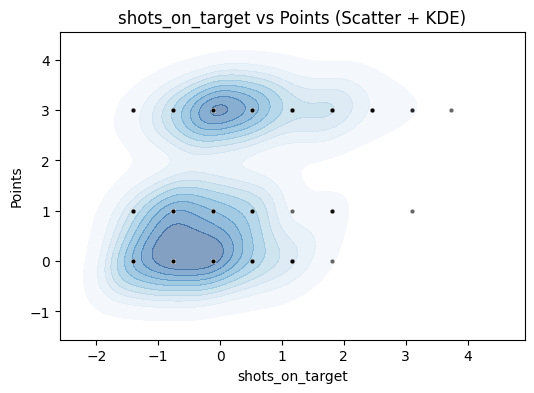

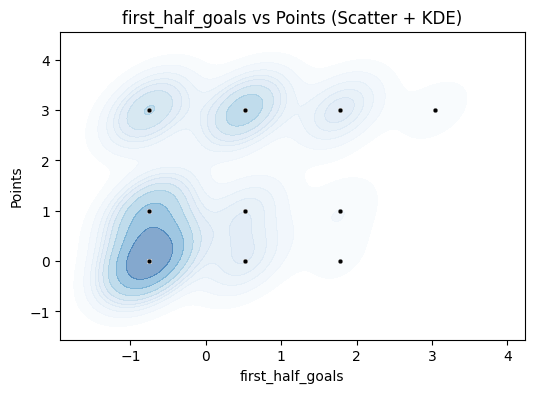

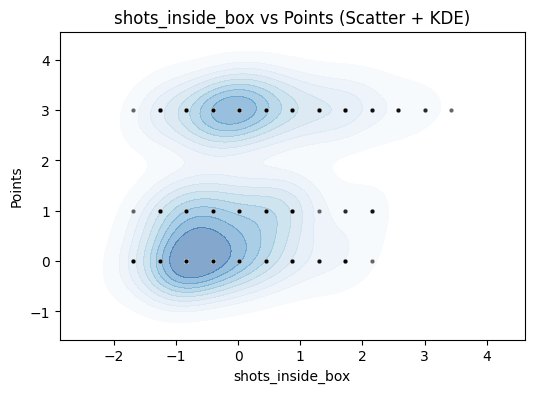

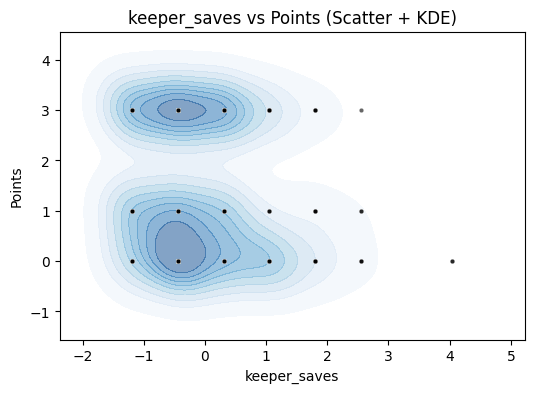

In [ ]:
for feature in df_points.columns[:-1]:  # Exclude 'points'
    plt.figure(figsize=(6, 4))
    sns.kdeplot(
        x=df_points[feature],
        y=df_points['points'],
        cmap='Blues',
        fill=True,
        alpha=0.5
    )
    sns.scatterplot(
        x=df_points[feature],
        y=df_points['points'],
        color='black',
        alpha=0.6,
        s=10  # Smaller points for better visibility
    )
    plt.title(f'{feature} vs Points (Scatter + KDE)')
    plt.xlabel(feature)
    plt.ylabel('Points')
    plt.show()


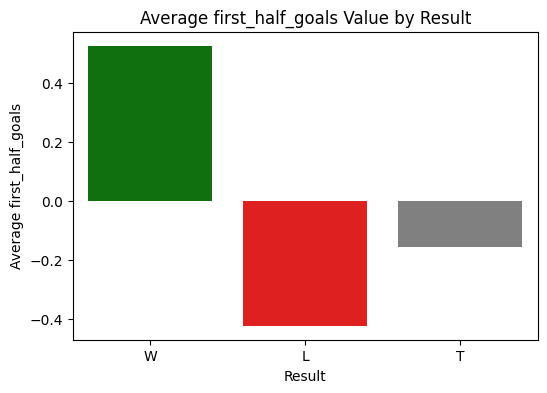

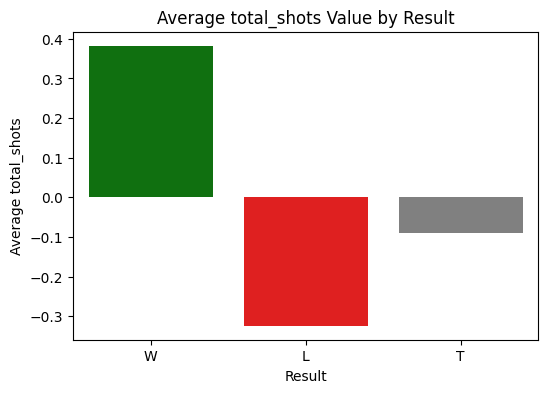

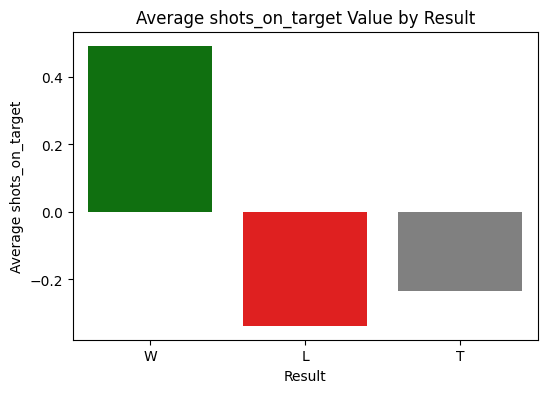

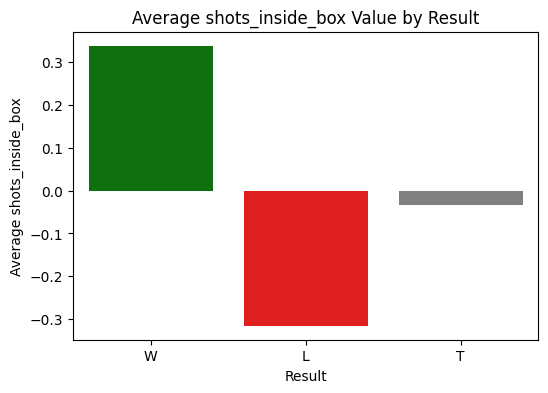

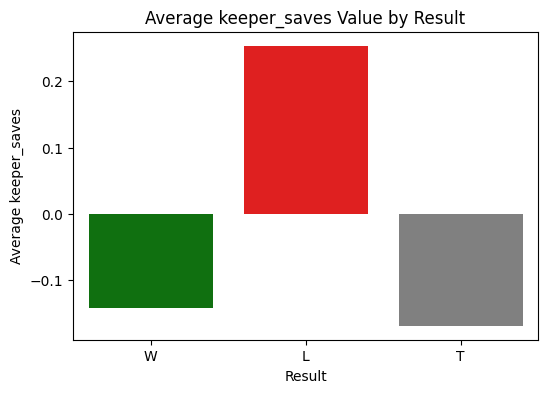

In [35]:
# Define a custom color palette for result
result_palette = {'W': 'green', 'T': 'gray', 'L': 'red'}

# Create bar plots with the custom result palette
for feature in df_selected.columns[:-2]:  # Exclude 'points' and 'result'
    plt.figure(figsize=(6, 4))
    sns.barplot(
        data=df_selected,
        x='result',  # Use 'result' for grouping
        y=feature,
        hue='result',  # Assign 'result' to hue
        palette=result_palette,  # Apply the custom palette for result
        errorbar=None,  # Disable error bars
        dodge=False  # Ensures no separation for hue groups
    )
    plt.title(f'Average {feature} Value by Result')
    plt.xlabel('Result')
    plt.ylabel(f'Average {feature}')
    plt.legend([], [], frameon=False)  # Remove the legend
    plt.show()


<ipython-input-36-7ce0aebcb541>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


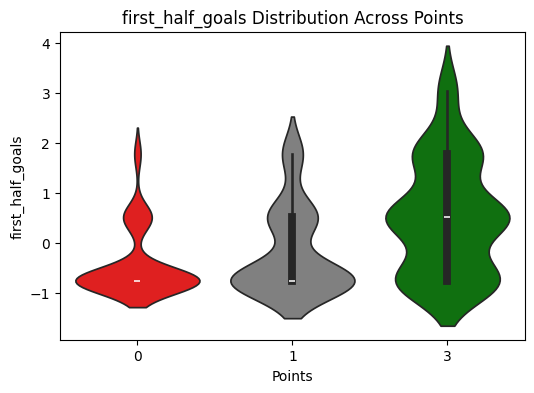

<ipython-input-36-7ce0aebcb541>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


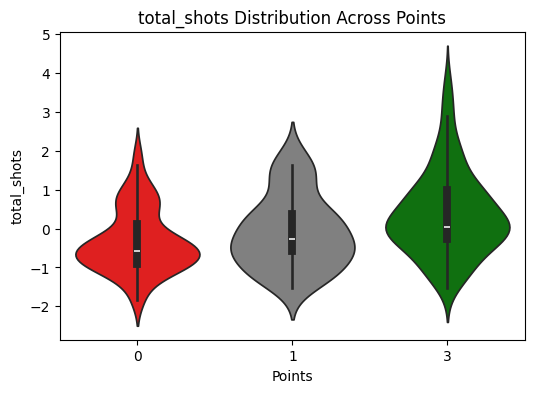

<ipython-input-36-7ce0aebcb541>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


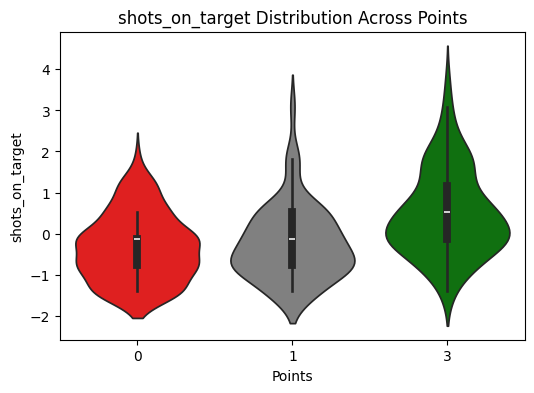

<ipython-input-36-7ce0aebcb541>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


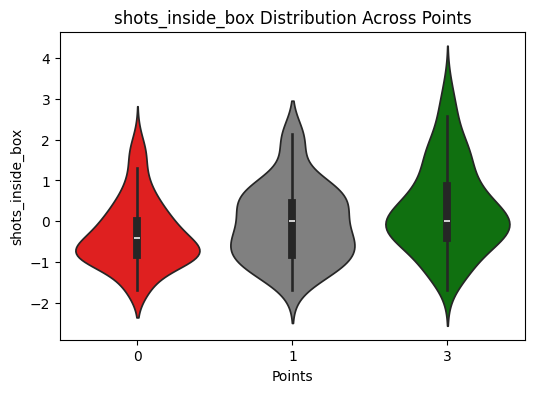

<ipython-input-36-7ce0aebcb541>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


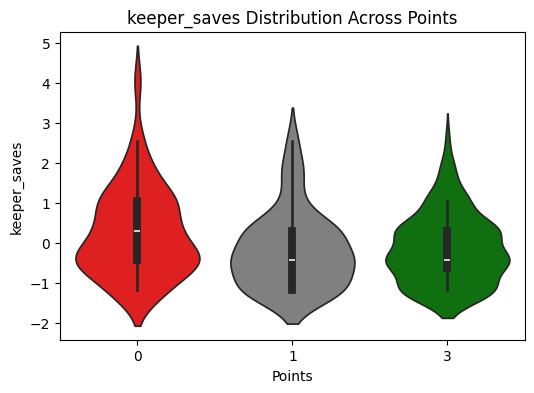

In [36]:
points_palette = {'3': 'green', '1': 'gray', '0': 'red'}

# Convert 'points' to a categorical variable with explicit ordering
df_points['points'] = df_points['points'].astype('category')

# Loop through features to create violin plots
for feature in df_points.columns[:-1]:  # Exclude 'points'
    plt.figure(figsize=(6, 4))
    sns.violinplot(
        data=df_points,
        x='points',
        y=feature,
        palette=points_palette  # Use the updated palette
    )
    plt.title(f'{feature} Distribution Across Points')
    plt.xlabel('Points')
    plt.ylabel(feature)
    plt.show()


Through these visualizations we can see how each factor influences and weights what the predicted outcome may be. For example, higher keeper saves seems to be correlated with losses, which makes sense in context because the more a keeper is having to save the ball means the more shots the other team is taking, likely indicating that the other teams is attacking aggresively and leading to beign scored on.

For next steps, I plan to create the multiclass classification model to use these half time statistics to predict if the game will end in a win, loss, or tie for that team. I will create a model that uses all of the features in the dataset and then create a model focusing on just these 5 features. I also plan to, as I began creating these models, check for collinearity and remove / combine very linear features for the model. My hope is that the model with fewer features will be similarly accurate so as not to have an overly complex model. I may also create a separate binary classification model (win / not win and/or loss / not loss) to see if this improves accuracy of the model and to have as another option for use in the future. For example, a win / not win model would be useful for playoff games where ties are not an option.

### Data Exploration and Preprocessing Report

#### Data Acquisition and Overview
The dataset consists of manually collected halftime statistics and final game results for all available National Women’s Soccer League (NWSL) games from the 2023 season, including playoff matches. Each game is represented as two observations—one for each team—recording halftime statistics and their corresponding match outcomes (win, loss, or tie). The data was manually entered from [FotMob](https://www.fotmob.com/leagues/9134/overview/nwsl) and saved as a CSV file for analysis. Observations with missing halftime statistics were excluded. The dataset also included a "full time goals" column, which was dropped as it would not be available at halftime for prediction purposes.

#### Initial Data Cleaning
Duplicate columns (e.g., variables ending in `.1`) and those with high proportions of missing values (e.g., `touches_in_opp_box`) were removed to ensure dataset quality. The target variable, `result`, was separated from the input features, and features were standardized using `StandardScaler` to normalize the data. Standardization helped ensure that no single feature dominated due to differences in scale, improving the performance of machine learning models. These preprocessing steps provided a clean and well-structured dataset for further analysis.

#### Exploratory Data Analysis
Several statistical methods were employed to understand the dataset and determine the most important features:

1. **Mutual Information (MI):**  
   MI analysis identified `total_shots` (MI = 0.136), `first_half_goals` (MI = 0.115), and `corners` (MI = 0.098) as the most informative features. Features like `big_chances_missed` and `successful_dribbles` had an MI score of 0.000, suggesting no dependency with the target variable.

2. **ANOVA (F-Statistic and p-values):**  
   The ANOVA test confirmed statistical significance for features such as `first_half_goals` (F = 28.37, p < 0.0001) and `shots_on_target` (F = 22.75, p < 0.0001). Conversely, features like `ball_possession` and `throws` exhibited very high p-values, indicating negligible impact on the target variable and warranting exclusion.

3. **Random Forest Feature Importances:**  
   A Random Forest classifier revealed `total_shots` (importance = 0.046) and `first_half_goals` (importance = 0.045) as the most impactful predictors. Features like `duels_won` and `successful_dribbles_percent` also showed moderate importance, while `red_cards` and `hit_woodwork` had minimal influence.

#### Feature Selection
To refine the dataset, a composite scoring system was used, combining normalized MI scores, F-statistics, and Random Forest importances. The top five features identified were:
- **Total Shots**
- **Shots on Target**
- **First Half Goals**
- **Shots Inside Box**
- **Keeper Saves**

These features not only ranked highly across multiple analyses but also aligned with domain knowledge—for instance, factors such as "total shots" or "first-half goals" are well-recognized indicators of success in soccer, as teams that take more shots or establish an early lead are generally more likely to win. This alignment supports their inclusion for predictive modeling, as it ensures the model captures meaningful and contextually relevant patterns, rather than relying solely on statistical correlations.

#### Visualizations and Insights
Visualizations reinforced the relationships between features and outcomes. For example, higher `keeper_saves` correlated with losses, likely indicating defensive pressure due to frequent opposition attacks. These insights helped contextualize statistical findings and guided feature prioritization.

#### Next Steps
Moving forward, I will develop multiclass classification models to predict game outcomes (win, loss, tie) using the entire dataset and a reduced feature set of the top five variables. Further analysis will include checking for collinearity and combining highly linear features if necessary. Additionally, binary classification models (e.g., win vs. not win) may be explored for applications such as playoff scenarios where ties are not possible. By comparing model accuracy with reduced and full feature sets, I aim to balance complexity and performance, optimizing the model for practical use cases.